# **Deep Hedging**
# Buchkov Viacheslav

In [1]:
import abc
import math
import os
import random
import sys
from functools import lru_cache
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

# You may add any imports you need
from torch.cuda.amp import GradScaler

RANDOM_SEED = 12

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(RANDOM_SEED)

In [3]:
if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [4]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

ROOT_PATH = Path("dataset")
PATH = Path("/content/gdrive/MyDrive/")
N_DAYS = 5

Mounted at /content/gdrive


In [5]:
# data = pd.read_pickle(PATH / "final_df.pkl")
# # data["rub_rate"] = data["rub_rate"] / 100
# data.dropna(inplace=True)
# data = data.resample("1 min").ffill()
# data

In [6]:
import abc

import numpy as np

from enum import Enum


class PositionSide(Enum):
    LONG = 1
    SHORT = -1



class Instrument:
    CALENDAR_DAYS: int = 365

    def __init__(self):
        pass

    def bid(self, margin: float) -> float:
        return self.price() - margin

    def offer(self, margin: float) -> float:
        return self.price() + margin

    @staticmethod
    def discount_factor(rate: float, term: float) -> float:
        return np.exp(-rate * term)

    @abc.abstractmethod
    def coupon(self, frequency: float = 0., *args, **kwargs) -> float:
        raise NotImplementedError

    @abc.abstractmethod
    def pv_coupons(self) -> float:
        raise NotImplementedError

    @abc.abstractmethod
    def price(self, spot_start: [float, list[float], None] = None) -> float:
        raise NotImplementedError

    @abc.abstractmethod
    def payoff(self, spot: [np.array, float]) -> float:
        raise NotImplementedError

    @abc.abstractmethod
    def __repr__(self):
        raise NotImplementedError

    def __str__(self):
        return self.__repr__()

    def __add__(self, other):
        return StructuredNote([(PositionSide.LONG, self), (PositionSide.LONG, other)])

    def __sub__(self, other):
        return StructuredNote([(PositionSide.LONG, self), (PositionSide.SHORT, other)])


class StructuredNote:
    def __init__(self, instruments: [list[tuple[PositionSide, Instrument]], None] = None):
        if instruments is not None:
            self.instruments = instruments
        else:
            self.instruments = []

    def bid(self, margin: float) -> float:
        return self.price() - margin

    def offer(self, margin: float) -> float:
        return self.price() + margin

    def coupon(self, frequency: float = 0., commission: float = 0., *args, **kwargs) -> float:
        return sum([instrument.coupon(frequency, commission) for _, instrument in self.instruments])

    def __add__(self, other: Instrument):
        return self.instruments.append((PositionSide.LONG, other))

    def __sub__(self, other: Instrument):
        return self.instruments.append((PositionSide.SHORT, other))

    def price(self) -> float:
        return sum([side.value * instrument.price() + instrument.pv_coupons() for side, instrument in self.instruments])

    def payoff(self, spot_paths: np.array) -> float:
        return sum([side.value * instrument.payoff(spot_paths) for side, instrument in self.instruments])

    def __repr__(self):
        sp_str = f"StructuredNote of:\n"
        for side, instrument in self.instruments:
            sp_str += f"* {side} -> {instrument}\n"
        return sp_str

    def __str__(self):
        return self.__repr__()


In [7]:
import numpy as np


class Forward(Instrument):
    def __init__(
            self,
            rates_difference: float,
            spot_price: float,
            term: float,
            *args,
            **kwargs
    ):
        super().__init__()
        self.rates_difference = rates_difference
        self.spot_price = spot_price
        self.term = term

    def coupon(self, frequency: float = 0., *args, **kwargs) -> float:
        return 0

    def pv_coupons(self) -> float:
        return 0

    def get_strike(self, spot_price: [float, None] = None) -> float:
        if spot_price is None:
            spot_price = self.spot_price
        return spot_price * self.discount_factor(rate=-self.rates_difference, term=self.term)

    @property
    def strike(self) -> float:
        return self.get_strike()

    def price(self, spot_start: [float, list[float], None] = None) -> float:
        return 0

    def payoff(self, spot: [float, np.array]) -> float:
        return spot - self.strike

    def __repr__(self):
        return f"Forward(strike={self.strike}, term={self.term}, spot_ref={self.spot_price})"


In [8]:
import numpy as np


class EuropeanCall(Instrument):
    def __init__(
            self,
            rates_difference: float,
            spot_price: float,
            term: float,
            *args,
            **kwargs
    ):
        super().__init__()
        self.rates_difference = rates_difference
        self.spot_price = spot_price
        self.term = term

    def coupon(self, frequency: float = 0., *args, **kwargs) -> float:
        return 0

    def pv_coupons(self) -> float:
        return 0

    def get_strike(self, spot_price: [float, None] = None) -> float:
        return self.spot_price

    @property
    def strike(self) -> float:
        return self.get_strike()

    def price(self, spot_start: [float, list[float], None] = None) -> float:
        return 0

    def payoff(self, spot: [float, np.array]) -> float:
        return max(spot - self.strike, 0)

    def __repr__(self):
        return f"EuropeanCall(strike={self.strike}, term={self.term}, spot_ref={self.spot_price})"

In [9]:
# from src.base.instrument import Instrument
# from src.forward.forward import Forward


def create_instrument(period_df: pd.DataFrame) -> Instrument:
    start = period_df.loc[period_df.index.min()]
    return EuropeanCall(
        rates_difference=start["rub_rate"] - start["usd_rate"],
        spot_price=start["ask"],
        term=N_DAYS / 365
    )

In [10]:
# data = pd.read_pickle(PATH / "final_df.pkl")

In [11]:
# tqdm.pandas()
# data.loc[data["embed"].map(len) < 128, "embed"] = data[data["embed"].map(len) < 128]["embed"].progress_apply(lambda embed: np.pad(embed, (0, 128 - len(embed)), 'constant', constant_values=0))

In [12]:
# data[data["embed"].map(len) < 128]

In [13]:
# tqdm.pandas()
# data = pd.read_pickle(PATH / "final_df.pkl")
# data["padded"] = data["embed"].progress_apply(lambda embed: np.pad(embed, (0, 128 - len(embed)), 'constant', constant_values=0))
# data

In [14]:
# data.to_pickle(PATH / "padded.pkl")

## Dataset.

In [15]:
MAX_LENGTH = 128

In [16]:
import datetime as dt

from typing import Union, Type
from torch.utils.data import Dataset

# from src.base.instrument import Instrument


class SpotDataset(Dataset):
    BID_COLUMN: str = "bid"
    ASK_COLUMN: str = "ask"
    RATE_DOMESTIC_COLUMN: str = "rub_rate"
    RATE_FOREIGN_COLUMN: str = "usd_rate"

    TRADING_DAYS: int = 252

    def __init__(
            self,
            instrument_cls: Type[Instrument],
            filename: str = "final_df",
            n_days: int = N_DAYS,
            path: Path = PATH,
            data: Union[pd.DataFrame, None] = None,
            max_length: int = MAX_LENGTH
    ):
        self.filename = filename

        self.instrument_cls = instrument_cls
        self.n_days = n_days
        self.max_length = max_length

        self.data = self._create_df(path) if data is None else data.copy()

        self.data["time_diff"] = self.data.index.to_series().diff()
        self.data.loc[self.data.index[0], "time_diff"] = pd.to_timedelta("0 days 00:00:00")
        self.data["time_diff"] = self.data["time_diff"].cumsum() / np.timedelta64(1, 'D') / 365
        # self.data["rub_rate"] = self.data["rub_rate"] / 100
        self.data.drop(["text", "lemmas"], axis=1, inplace=True)

        # self.data = self.data.dropna()
        self.data = self.data.resample("30 min").ffill()
        self.data = self.data.dropna()
        # self.X, self.y = self._create_dataset()

    def _create_df(self, path: Path) -> pd.DataFrame:
        if f"{self.filename}.pkl" in os.listdir(path):
            return pd.read_pickle(PATH / f"{self.filename}.pkl")
        else:
            pass

    def _create_instrument(self, period_df: pd.DataFrame) -> Instrument:
        start = period_df.loc[period_df.index.min()]
        spot_start = (start["bid"] + start["ask"]) / 2
        return self.instrument_cls(
            rates_difference=start["rub_rate"] - start["usd_rate"],
            spot_price=spot_start,
            term=N_DAYS / 365
        ), spot_start

    def __len__(self):
        return len(self.data[self.data.index < self.data.index.max() - dt.timedelta(days=self.n_days)])

    def __getitem__(self, idx: int):
        start_date = self.data.index[idx]
        end_date = start_date + dt.timedelta(days=self.n_days)

        features = self.data[(self.data.index >= start_date) & (self.data.index <= end_date)].copy()
        features["time_diff"] = features.iloc[-1, -1] - features["time_diff"]

        try:
            embeds = torch.stack(features["embed"].tolist())[:, :128, :]
        except:
            print(features["embed"].tolist())
        features.drop(["embed"], axis=1, inplace=True)

        instrument, spot_start = self._create_instrument(features)
        # features["spot_start"] = spot_start
        target = instrument.payoff(spot=features.ask.iloc[-1])

        return torch.Tensor(features.to_numpy()).to(torch.float32), torch.Tensor(embeds).to(torch.float32), torch.Tensor([target]).to(torch.float32)

    @property
    def average_dt(self):
        return self.data.index.to_series().diff(1).mean() / (np.timedelta64(1, 'D') * self.TRADING_DAYS)

In [17]:
spot_dataset = SpotDataset(filename="final_df", instrument_cls=EuropeanCall)
spot_dataset[-2][1].shape

torch.Size([2, 128, 128])

In [18]:
AVERAGE_DT = spot_dataset.average_dt
AVERAGE_DT

8.267195767195767e-05

In [19]:
# spot_dataset[101][0].shape

In [20]:
def get_pnl(spot: torch.Tensor, weights: torch.Tensor, dt: float = AVERAGE_DT) -> torch.float32:
    model_device = spot.device
    weights_all = torch.concat([torch.zeros(spot.shape[0], 1, requires_grad=False).to(model_device), weights,
                                torch.zeros(spot.shape[0], 1, requires_grad=False).to(model_device)], dim=1)
    weights_diff = weights_all.diff(n=1, dim=1)

    rates_diff = spot[:, :, 2] - spot[:, :, 3]

    bought = torch.where(weights_diff > 0, weights_diff, 0)
    sold = torch.where(weights_diff < 0, weights_diff, 0)

    interest = (rates_diff * -weights_all).sum(dim=1) * dt

    cash_outflow = (-spot[:, 1:, 1] * bought).sum(dim=1)
    cash_inflow = (-spot[:, 1:, 0] * sold).sum(dim=1)

    return (cash_outflow + cash_inflow + interest).unsqueeze(1)

In [21]:
class NeuralHedger(nn.Module):
    def __init__(
        self,
        input_size: int = 5,
        num_layers: int = 5,
        hidden_size: int = 32,
        dt: float = AVERAGE_DT,
        embed_size: float = 128,
        num_embed: int = 128
    ):
        super().__init__()
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dt = dt

        self.batch_norm = nn.BatchNorm1d(241)

        self.lstm_text = nn.LSTM(num_embed, 32, num_layers=3, batch_first=True, bidirectional=True)

        self.sentence = nn.Sequential(
            nn.Linear(2 * self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 1)
        )

        self.lstm = nn.LSTM(input_size + embed_size, self.hidden_size, num_layers=num_layers, batch_first=True)

        self.hedging_weights = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 1)
        )

    def forward(self, spot: torch.Tensor, text: torch.Tensor, hidden: [(torch.Tensor), None] = None, return_hidden: bool = False) -> [
        torch.Tensor,
        (torch.Tensor, torch.Tensor, torch.Tensor)]:
        model_device = spot.device
        if hidden is None:
            h_t = torch.zeros(self.num_layers, spot.size(0), self.hidden_size, dtype=torch.float32).to(model_device)
            c_t = torch.zeros(self.num_layers, spot.size(0), self.hidden_size, dtype=torch.float32).to(model_device)
        elif len(hidden) != 2:
            raise ValueError(f"Expected two hidden state variables, got {len(hidden)}")
        else:
            h_t, c_t = hidden

        hidden = []
        for input_t in text.chunk(text.size(0), dim=0):
            h, c = self.lstm_text(input_t.squeeze(0))
            x = self.sentence(h)
            hidden.append(x.squeeze(1))
        hidden = torch.stack(hidden).squeeze(3)

        price = self.batch_norm(spot[:, :, :2])
        rates = self.batch_norm(spot[:, :, 2:4])
        spot = torch.cat([price, rates, spot[:, :, 4:], hidden], dim=2)

        h_t, c_t = self.lstm(spot, (h_t, c_t))
        outputs = self.hedging_weights(h_t)[:, 1:-1, :].squeeze(2)

        if return_hidden:
            return outputs, (h_t, c_t)
        else:
            return outputs

    def get_pnl(self, spot: torch.Tensor, text: torch.Tensor) -> [torch.Tensor, torch.float32]:
        # hedging_weights = nn.Softmax()(self.forward(spot, return_hidden=False), dim=XXX)
        weights = self.forward(spot, text, return_hidden=False)

        model_device = spot.device
        weights_all = torch.concat([torch.zeros(spot.shape[0], 1, requires_grad=False).to(model_device), weights,
                                    torch.zeros(spot.shape[0], 1, requires_grad=False).to(model_device)], dim=1)
        weights_diff = weights_all.diff(n=1, dim=1)

        rates_diff = spot[:, :, 2] - spot[:, :, 3]

        bought = torch.where(weights_diff > 0, weights_diff, 0)
        sold = torch.where(weights_diff < 0, weights_diff, 0)

        interest = (rates_diff * -weights_all).sum(dim=1) * self.dt

        cash_outflow = (-spot[:, 1:, 1] * bought).sum(dim=1)
        cash_inflow = (-spot[:, 1:, 0] * sold).sum(dim=1)

        pnl = (cash_outflow + cash_inflow + interest).unsqueeze(1)

        return weights, pnl

In [22]:
# for features, text, target_pnl in loader:
#     w = hedger(features.to(DEVICE), text.to(DEVICE))
#     break
# w

In [23]:
# hedger = NeuralHedger().to(DEVICE)
# loader = DataLoader(SpotDataset(instrument_cls=EuropeanCall), batch_size=32, shuffle=True, drop_last=False)

# for features, text, target_pnl in loader:
#     w = hedger(features.to(DEVICE), text.to(DEVICE))
#     break
# w

In [24]:
from tqdm import tqdm
from torch.utils.data import DataLoader


def train_epoch(model: nn.Module, optimizer: torch.optim.Optimizer, criterion: nn.Module,
                loader: DataLoader, tqdm_desc: str = "Model"):
    device = next(model.parameters()).device

    if tqdm_desc is None:
        iterator = loader
    else:
        iterator = tqdm(loader, desc=tqdm_desc)

    train_loss = 0.0
    model_diff = 0.0
    model.train()
    scaler = GradScaler()
    pnl_path = []
    weight_path = []
    diffs_path = []
    for features, text, target_pnl in iterator:
        optimizer.zero_grad()

        features = features.to(device)
        text = text.to(device)
        target_pnl = target_pnl.to(device)

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            weights, model_pnl = model.get_pnl(features, text)
            loss = criterion(target_pnl, model_pnl)

        scaler.scale(loss).backward()
        scaler.step(optimizer)

        scaler.update()

        diff = target_pnl - model_pnl

        train_loss += loss.item()
        model_diff += diff.mean().item()

        diffs_path.append(diff.detach().cpu().numpy())
        weight_path.append(weights.detach().cpu().numpy())

    train_loss /= len(loader.dataset)
    model_diff /= len(loader.dataset)

    return train_loss, weight_path, model_diff, diffs_path


@torch.no_grad()
def validation_epoch(model: nn.Module, criterion: nn.Module,
                     loader: DataLoader, tqdm_desc: [str, None] = None):
    device = next(model.parameters()).device

    if tqdm_desc is None:
        iterator = loader
    else:
        iterator = tqdm(loader, desc=tqdm_desc)

    val_loss = 0.0
    model_diff = 0.0
    model.eval()
    diffs_path = []
    weight_path = []
    for features, text, target_pnl in iterator:
        features = features.to(device)
        text = text.to(device)
        target_pnl = target_pnl.to(device)

        weights, model_pnl = model.get_pnl(features, text)

        loss = criterion(target_pnl, model_pnl)
        diff = target_pnl - model_pnl

        val_loss += loss.item()
        model_diff += diff.mean().item()

        diffs_path.append(diff.detach().cpu().numpy())
        weight_path.append(weights.detach().cpu().numpy())

    val_loss /= len(loader.dataset)
    model_diff /= len(loader.dataset)

    return val_loss, weight_path, model_diff, diffs_path

In [25]:
from IPython.display import clear_output

def plot_losses(train_losses: list[float], val_losses: list[float], train_pnls: list[float], val_pnls: list[float]):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_pnls) + 1), train_pnls, label='train')
    axs[1].plot(range(1, len(val_pnls) + 1), val_pnls, label='val')
    axs[1].set_ylabel('PnL, RUB')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [26]:
from typing import Tuple, List, Optional, Any


def train(model: nn.Module, optimizer: torch.optim.Optimizer, scheduler: Optional[Any],
          train_loader: DataLoader, val_loader: DataLoader,
          num_epochs: int, print_logs: bool = True) -> Tuple[List[float], List[float]]:
    train_losses, val_losses = [], []
    train_diffs, val_diffs = [], []
    criterion = nn.MSELoss().to(DEVICE)

    for epoch in range(1, num_epochs + 1):
        if print_logs:
            desc_train = f"Training {epoch}/{num_epochs}"
            desc_val = f"Validation {epoch}/{num_epochs}"
        else:
            desc_train, desc_val = None, None

        train_loss, weights, train_diff, train_path = train_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=desc_train
        )
        val_loss, weights, val_diff, val_path = validation_epoch(
            model, criterion, val_loader,
            tqdm_desc=desc_val
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        val_losses += [val_loss]

        train_diffs += [train_diff]
        val_diffs += [val_diff]

        plot_losses(train_losses, val_losses, train_diffs, val_diffs)

    return train_losses, val_losses, weights, train_diffs, val_diffs

In [27]:
import matplotlib.pyplot as plt

def assess_model(model: nn.Module, baseline: nn.Module) -> None:
    _, weights, _, model_diff = validation_epoch(model, nn.MSELoss(), val_loader)
    _, _, _, baseline_diff = validation_epoch(baseline, nn.MSELoss(), val_loader)

    model_diff = np.concatenate(model_diff, axis=0)
    baseline_diff = np.concatenate(baseline_diff, axis=0)

    # print(weights[-1])
    # print(model_diff)

    print(f"Average weight = {weights[-1].mean()}, Weights = [{weights[-1].min()}; {weights[-1].max()}]")

    print(f"Means: model = {model_diff.mean():.6f}, baseline = {baseline_diff.mean():.6f}")

    print(f"Stds: model = {model_diff.std():.6f}, baseline = {baseline_diff.std():.6f}")

    print(f"VaRs 5%: model = {np.abs(np.quantile(model_diff, 0.05)):.6f}, baseline = {np.abs(np.quantile(baseline_diff, 0.05)):.6f}")

    t_value = (model_diff.mean() - baseline_diff.mean()) / np.sqrt(model_diff.std() ** 2 / model_diff.shape[0] + baseline_diff.std() ** 2 / baseline_diff.shape[0])
    print(f"T-stat = {t_value:.6f}")

    bins = np.linspace(-.25, .25, 100)

    plt.hist(model_diff, bins, alpha=0.5, label='model')
    plt.hist(baseline_diff, bins, alpha=0.5, label='baseline')
    plt.legend(loc='upper right')
    plt.show()

## Option.

In [28]:
class BaselineEuropeanCall(nn.Module):
    def __init__(self, dt: float = AVERAGE_DT):
        super().__init__()

        self.lstm = nn.LSTM(1, 1, num_layers=1, batch_first=True)
        self.dt = dt

        self.strike = 1

    def _call_delta(self, mid: torch.Tensor, rates: torch.Tensor, terms: torch.Tensor) -> torch.float32:
        """
        Call option delta [dV/dS] via analytical form solution of Black-Scholes-Merton.

        Returns
        -------
        delta : float
            Option delta.
        """
        strikes = mid[:, 0] * self.strike
        # print(strikes[: -1])
        sigma = mid.std(dim=1).unsqueeze(1)
        # print("***")
        d1 = (torch.log(mid / strikes.unsqueeze(1)) + (rates + sigma ** 2 / 2) * terms) / (sigma * torch.sqrt(terms))
        d1 = d1[:, 1:-1]
        # print(d1.shape)
        # print("***")

        cdf_d1 = torch.distributions.normal.Normal(0, 1).cdf(d1)

        return cdf_d1

    def forward(self, spot: torch.Tensor, text: torch.Tensor = None, return_hidden: bool = False) -> torch.Tensor:
        mid = (spot[:, :, 0] + spot[:, :, 1]) / 2
        rates = spot[:, :, 2] - spot[:, :, 3]
        terms = spot[:, :, 4]
        return self._call_delta(mid=mid, rates=rates, terms=terms)

    def get_pnl(self, spot: torch.Tensor, text: torch.Tensor) -> torch.float32:
        # hedging_weights = nn.Softmax()(self.forward(spot, return_hidden=False), dim=XXX)
        hedging_weights = self.forward(spot, text, return_hidden=False)
        return hedging_weights, get_pnl(spot=spot, weights=hedging_weights, dt=self.dt)

In [29]:
class BaselineTrivial(nn.Module):
    def __init__(self, dt: float = AVERAGE_DT):
        super().__init__()

        self.lstm = nn.LSTM(1, 1, num_layers=1, batch_first=True)
        self.dt = dt

    def forward(self, spot: torch.Tensor, return_hidden: bool = False) -> torch.Tensor:
        return torch.Tensor([[0] * (spot.shape[1] - 2)] * spot.shape[0]).to(torch.float32).to(DEVICE)

    def get_pnl(self, spot: torch.Tensor) -> torch.float32:
        # hedging_weights = nn.Softmax()(self.forward(spot, return_hidden=False), dim=XXX)
        hedging_weights = self.forward(spot, return_hidden=False)
        return hedging_weights, get_pnl(spot=spot, weights=hedging_weights, dt=self.dt)

In [30]:
# TEST_SIZE = .1
# train_data = data.resample("30 min").ffill()
# time_split = train_data.index[int(train_data.index.shape[0] * (1 - TEST_SIZE))]
# train_df, test_df = train_data[train_data.index <= time_split], train_data[train_data.index > time_split]

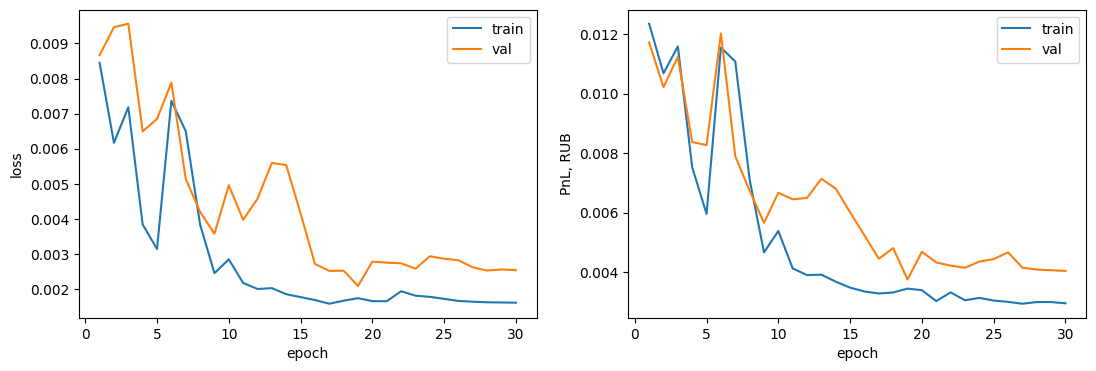

In [31]:
N_EPOCHS = 30

hedger = NeuralHedger().to(DEVICE)

train_set = SpotDataset(instrument_cls=EuropeanCall)
val_set = SpotDataset(instrument_cls=EuropeanCall)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, drop_last=True)

optimizer = torch.optim.Adam(hedger.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)

train_losses, val_losses, weights, train_diffs, val_diffs = train(
    model=hedger,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=N_EPOCHS,
    print_logs=True
)

Average weight = 0.31084775924682617, Weights = [0.07071627676486969; 1.9503787755966187]
Means: model = 0.129199, baseline = 0.450233
Stds: model = 0.254065, baseline = 0.341319
VaRs 5%: model = 0.256264, baseline = 0.141976
T-stat = -133.679157


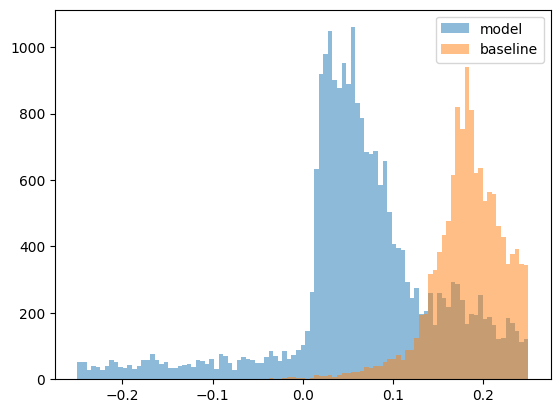

In [32]:
assess_model(hedger, BaselineEuropeanCall().to(DEVICE))

In [33]:
torch.save(hedger, PATH / "opt_еучеы.pt")

# 5 min

In [ ]:
TEST_SIZE = .1
train_data = data.resample("5 min").ffill()
time_split = train_data.index[int(train_data.index.shape[0] * (1 - TEST_SIZE))]
train_df, test_df = train_data[train_data.index <= time_split], train_data[train_data.index > time_split]

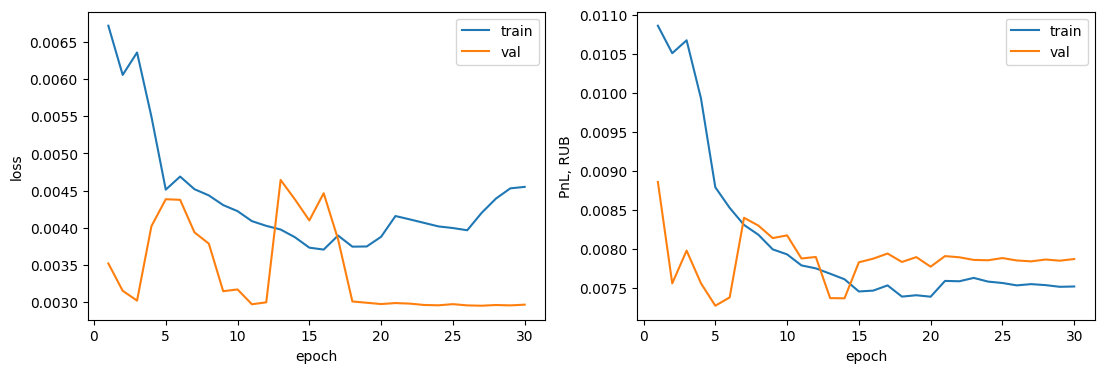

In [ ]:
N_EPOCHS = 30

hedger = NeuralHedger().to(DEVICE)

train_set = SpotDataset(data=train_df, instrument_cls=EuropeanCall)
val_set = SpotDataset(data=test_df, instrument_cls=EuropeanCall)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=False)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, drop_last=False)

optimizer = torch.optim.Adam(hedger.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)

train_losses, val_losses, weights, train_diffs, val_diffs = train(
    model=hedger,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=N_EPOCHS,
    print_logs=True
)

Average weight = 0.4691721498966217, Weights = [0.03623202443122864; 0.473453164100647]
Means: model = 0.251576, baseline = 0.296768
Stds: model = 0.177280, baseline = 0.102164
VaRs 5%: model = 0.030674, baseline = 0.162510
T-stat = -33.828085


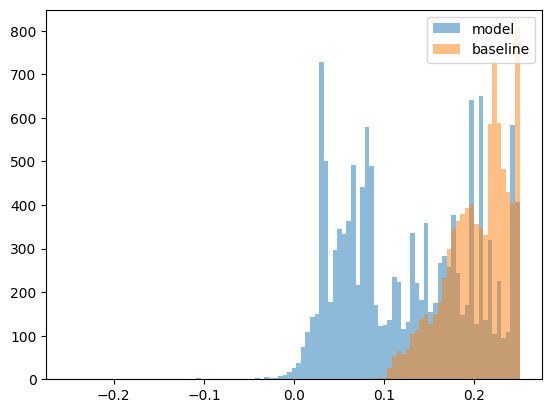

In [ ]:
assess_model(hedger, BaselineEuropeanCall().to(DEVICE))

In [ ]:
torch.save(hedger, PATH / "opt_out_new_30_bn_till_sgd.pt")